In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from tune_model import tune #function to tune hyperparameters

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

In [28]:
# load the dataset
data = pd.read_csv('../../data/definitive_dataset.csv')

# convert date columns to date with no time
data['date'] = pd.to_datetime(data['date'])

In [29]:
def create_date_permno_column(data):
    
    # convert date to datetime
    data['date'] = pd.to_datetime(data['date'])

    # keep only the date
    data['date'] = data['date'].dt.date

    # create a column that is the concatenation of date and permno
    data['date_permno'] = data['date'].astype(str) + '_' + data['permno'].astype(str)

    return data

In [30]:
# load the price data
price_data = pd.read_csv('../../data/backtest_prices.csv')

# create a new column in the price data that is permno
price_data = create_date_permno_column(price_data)

# change the name of the prc_adj column to price
price_data.rename(columns={'prc_adj': 'price'}, inplace=True)

print('Price data columns:', price_data.columns)
print('Head of price data:', price_data.head())

Price data columns: Index(['date', 'permno', 'prc', 'cfacpr', 'cfacshr', 'divamt', 'adj_prc',
       'adj_prc_w_dividend', 'Ticker', 'date_permno'],
      dtype='object')
Head of price data:          date  permno    prc  cfacpr  cfacshr  divamt  adj_prc  \
0  2008-01-02   10299  30.95     1.0      1.0     0.0    30.95   
1  2008-01-02   10137  62.95     1.0      1.0     0.0    62.95   
2  2008-01-03   10137  63.47     1.0      1.0     0.0    63.47   
3  2008-01-04   10137  62.64     1.0      1.0     0.0    62.64   
4  2008-01-07   10137  63.06     1.0      1.0     0.0    63.06   

   adj_prc_w_dividend Ticker       date_permno  
0               30.95   LLTC  2008-01-02_10299  
1               62.95    AYE  2008-01-02_10137  
2               63.47    AYE  2008-01-03_10137  
3               62.64    AYE  2008-01-04_10137  
4               63.06    AYE  2008-01-07_10137  


In [31]:
price_data.rename(columns={'adj_prc': 'price'}, inplace=True)

In [32]:
# count negative prices
print('Number of negative prices:', price_data[price_data['price'] < 0].shape[0])
print('Mean of negative prices:', price_data[price_data['price'] < 0]['price'].mean())

# remove negative prices
price_data = price_data[price_data['price'] >= 0]

Number of negative prices: 0
Mean of negative prices: nan


In [33]:
# load the features as pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    features = pkl.load(f)

# print the keys
print(features.keys())

dict_keys([Timestamp('2008-01-01 00:00:00'), Timestamp('2010-01-01 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00')])


In [34]:
# drop rows with missing target value
data.dropna(subset=['target'], inplace=True)

In [35]:
# define starting dates for the periods
training_starting_dates = ['2008-01-01','2010-01-01', '2012-01-01', '2014-01-01', '2016-01-01', '2018-01-01']

In [36]:
def find_first_trading_day(date, data, direction, consider_current_date=True):

    first_date = data['date'].min()
    last_date = data['date'].max()
    
    if not consider_current_date:
        if direction == 'forward':
            date = date + pd.DateOffset(days=1)
        elif direction == 'backward':
            date = date - pd.DateOffset(days=1)
    
    while date not in data['date'].values:
        if direction == 'forward':
            date = date + pd.DateOffset(days=1)
            if date > last_date:
                return last_date
        elif direction == 'backward':
            date = date - pd.DateOffset(days=1)
            if date < first_date:
                return first_date
    return date

In [37]:
holding_period = 90

# make a dataframe with the metrics for each model
metrics = pd.DataFrame(columns=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'])

# evaluate the models for each starting date
for i, training_date in enumerate(training_starting_dates):

    training_date_str = training_date
    training_date = pd.to_datetime(training_date)

    start_trading_date = training_date + pd.DateOffset(years=2)
    start_trading_date_str = str(start_trading_date.date())

    first_trading_date = find_first_trading_day(start_trading_date, data, 'forward')
    last_trading_date = start_trading_date + pd.DateOffset(years=2) - pd.DateOffset(days=1)
    
    # subset the data to the period of interest
    training_data = data[(data['date'] >= start_trading_date) & (data['date'] <= last_trading_date)]

    # find the selected features for the period of interest
    training_features = features[training_date]
    training_date_str = training_date.strftime('%Y-%m-%d')
    model_name = f'xg_boost_mkII_{training_date_str}_500_correct_dataset'

    # load model 1 as pickle
    with open(f'../../models/final_models/{model_name}.pkl', 'rb') as f:
        model1 = pkl.load(f)

    # load model 2 as pickle
    with open(f'../../models/final_models/{model_name}.pkl', 'rb') as f:
        model2 = pkl.load(f)

    X = training_data[training_features]
    y = training_data['target']

    # make predictions
    #y_pred1 = model1.predict(X)
    y_pred2 = model2.predict(X.copy())

    #metrics.loc['model1'] = [accuracy_score(y, y_pred1), roc_auc_score(y, y_pred1), f1_score(y, y_pred1), precision_score(y, y_pred1), recall_score(y, y_pred1)]
    metrics.loc[f'{start_trading_date_str}'] = [accuracy_score(y, y_pred2), roc_auc_score(y, y_pred2), f1_score(y, y_pred2), precision_score(y, y_pred2), recall_score(y, y_pred2)]

# name the index
metrics.index.name = 'test_start_date'

In [38]:
# print the rounded metrics
print(metrics.round(3))

                 accuracy  roc_auc     f1  precision  recall
test_start_date                                             
2010-01-01          0.524    0.525  0.574      0.636   0.523
2012-01-01          0.499    0.509  0.566      0.686   0.481
2014-01-01          0.524    0.505  0.618      0.553   0.699
2016-01-01          0.507    0.509  0.579      0.683   0.502
2018-01-01          0.546    0.525  0.642      0.564   0.745
2020-01-01          0.516    0.527  0.574      0.684   0.494


In [39]:
def subset_data_to_current(data, prediction_method, current_trading_date, num_days):
    if prediction_method == 'single_day':
                # data on the current trading date
                current_data = data[data['date'] == current_trading_date]

    elif prediction_method == 'multi_day':
        dates = [current_trading_date]
        
        while len(dates) < num_days:
            next_date = find_first_trading_day(current_trading_date, data, 'backward', consider_current_date=False)
            dates.append(next_date)
            current_trading_date = next_date
        current_data = data[data['date'].isin(dates)]

    return current_data

In [40]:
def create_prediction_df(current_data_info, y_prob):
    # create a dataframe to store the predictions and the permnos
    predictions = pd.DataFrame(
        {
            'permno': current_data_info['permno'],
            'prob_0': y_prob[:, 0],
            'prob_1': y_prob[:, 1]
        }
    )

    return predictions

In [41]:
def find_top_permnos_to_trade(predictions_df, num_permnos_to_trade, short, threshold):

    # sort the predictions by the probability of being in the positive class
    predictions_df.sort_values(by='prob_1', ascending=False, inplace=True)
    
    # find the top permnos to trade
    if type(threshold) == type(None):
        top_long_permnos = predictions_df['permno'].values[:num_permnos_to_trade[0]]
    else:
        top_long_permnos = predictions_df[predictions_df['prob_1'] >= threshold]['permno'].values

        if len(top_long_permnos) < num_permnos_to_trade[0]:
            top_long_permnos = predictions_df['permno'].values[:num_permnos_to_trade[0]]

    if not short:
        return top_long_permnos, None

    # find the bottom permnos to trade
    predictions_df.sort_values(by='prob_0', ascending=False, inplace=True)

    if type(threshold) == type(None):
        top_short_permnos = predictions_df['permno'].values[:num_permnos_to_trade[1]]
    else:
        top_short_permnos = predictions_df[predictions_df['prob_0'] >= threshold]['permno'].values

        if len(top_short_permnos) < num_permnos_to_trade[1]:
            top_short_permnos = predictions_df['permno'].values[:num_permnos_to_trade[1]]
    
    return top_long_permnos, top_short_permnos

In [42]:
def find_next_trading_day(current_date, data, holding_period):

    next_trading_date = current_date + pd.DateOffset(days=holding_period)
    next_trading_date = find_first_trading_day(next_trading_date, data, 'forward')

    return next_trading_date

In [43]:
def calculate_returns(price_data, long_permnos, short_permnos, current_trading_date, next_trading_date, short):
        
        if short:
                permnos = np.concatenate((long_permnos, short_permnos))
        else:
                permnos = long_permnos

        # keep only the date removing the time from the current trading date and the next trading date
        current_trading_date = current_trading_date.date()
        next_trading_date = next_trading_date.date()

        # create a new df with current prices
        current_prices = price_data[price_data['date'] == current_trading_date].copy()

        # create a new df with next prices
        next_prices = price_data[price_data['date'] == next_trading_date].copy()

        # subset the current prices to the permnos of interest
        current_prices = current_prices[current_prices['permno'].isin(permnos)]

        # subset the next prices to the permnos of interest
        next_prices = next_prices[next_prices['permno'].isin(permnos)]

        # subsitute the date_permno column using the current trading date instead of the next trading date
        next_prices['date'] = current_trading_date
        next_prices = create_date_permno_column(next_prices)


        # merge the two dataframes
        merged_prices = current_prices.merge(next_prices, on='date_permno', suffixes=('_current', '_next'))

        # change the permno_current to permno
        merged_prices.rename(columns={'permno_current': 'permno'}, inplace=True)

        # calculate the returns
        merged_prices['return'] = (merged_prices['price_next'] - merged_prices['price_current']) / merged_prices['price_current']

        long_return_df = merged_prices[merged_prices['permno'].isin(long_permnos)]

        if not short:
                return long_return_df, None
        
        short_return_df = merged_prices[merged_prices['permno'].isin(short_permnos)]

        # find negative returns that are less than -1
        strange_returns = merged_prices[merged_prices['return'] < -1]
        
        # print rows corresponding to strange returns
        if strange_returns.shape[0] > 0:
            print('-'*50)
            print('-'*50)
            print('Strange returns:')
            print(strange_returns)
            print('-'*50)
            print('-'*50)

        cols_to_return = ['permno', 'return']
    
        return long_return_df[cols_to_return], short_return_df[cols_to_return]

In [44]:
def equal_weights(returns_df):

        if len(returns_df) == 0:
                return np.float64(0)

        # count number of nan values in the returns
        num_nan = returns_df['return'].isna().sum()

        avg_return = (returns_df['return'].mean() * (returns_df.shape[0] - num_nan) - (1 * num_nan))/(returns_df.shape[0])
    
        return avg_return

In [47]:
def trade(data, price_data, features, training_starting_dates, prediction_method,  num_days, weight_slector, threshold=None, holding_period=2, num_stocks=[15, 15], short=True):
    if type(threshold) != type(None):
        print('WARNING: Threshold is not None, num_stocks will be ignored used as minimum number of stocks.\n')
    total_return = 1
    if short:
        returns_df = pd.DataFrame(columns=['date', 'long_return', 'short_return', 'return', 'n_long', 'n_short'])
    else:
        returns_df = pd.DataFrame(columns=['date', 'return', 'n_long'])

    # evaluate the models for each starting date
    for i, training_date in enumerate(training_starting_dates):

        # convert the date to string
        training_date_str = training_date

        # convert the date to datetime
        training_date = pd.to_datetime(training_date)

        # find the start trading date
        start_trading_date = training_date + pd.DateOffset(years=2)

        # find the first trading date, which is the first date in the dataset after the start trading date
        first_trading_date = find_first_trading_day(start_trading_date, data, 'forward')

        # find the last trading date, which is the date two years after the start trading date
        last_trading_date = start_trading_date + pd.DateOffset(years=2) - pd.DateOffset(days=1)

        training_date_str = training_date.strftime('%Y-%m-%d')
        model_name = f'xg_boost_mkII_{training_date_str}_500_correct_dataset'
        # load model 1 as pickle
        with open(f'../../models/final_models/{model_name}.pkl', 'rb') as f:
            model = pkl.load(f)

        # subset the data to the period of interest
        selected_features = features[training_date]

        current_trading_date = first_trading_date

        while current_trading_date < last_trading_date:

            current_data = subset_data_to_current(data, prediction_method, current_trading_date, num_days)
            
            current_data_info = current_data[['date', 'permno', 'target']]
            current_data = current_data[selected_features]
            
            # predict probabilities
            y_prob = model.predict_proba(current_data)

            # create a dataframe to store the predictions and the permnos
            predictions_df = create_prediction_df(current_data_info, y_prob)

            # take the average of the probabilities by permno if the prediction method is multi_day
            if prediction_method == 'multi_day':
                predictions_df['prob_0'] = predictions_df.groupby('permno')['prob_0'].transform('mean')
                predictions_df['prob_1'] = predictions_df.groupby('permno')['prob_1'].transform('mean')

            #print('Predictions head:', predictions_df.head())

            # find the permnost to go long and short
            top_long_permnos, top_short_permnos = find_top_permnos_to_trade(predictions_df, num_stocks, short, threshold=threshold)

            n_long = len(top_long_permnos)
            print(f'Long stocks: {top_long_permnos}')
            print('Number of long stocks:', n_long)
            if short:
                n_short = len(top_short_permnos)
                print(f'Short stocks: {top_short_permnos}')
                print('Number of short stocks:', n_short)

            #print('Top long permnos:', top_long_permnos)

            # find the next trading date
            next_trading_date = find_next_trading_day(current_trading_date, data, holding_period)

            #print('Next trading date:', next_trading_date)

            # calculate the returns for the selected permnos
            long_return_df, short_return_df = calculate_returns(price_data, top_long_permnos, top_short_permnos, current_trading_date, next_trading_date, short)


            #print('Long return df:', long_return_df.head())

            long_return = weight_slector(long_return_df)
            period_return = long_return * n_long
            if short:
                short_return = -weight_slector(short_return_df)
                period_return += short_return * n_short
            
            period_return = period_return / (n_long + n_short) if short else period_return / n_long

            total_return *= (1+period_return)

            print(f'Period from {current_trading_date.date()} to {next_trading_date.date()}:')
            if short:
                print(f'Long return: {(long_return*100).round(2)}%, Short return: {(short_return*100).round(2)}%, Period return: {(period_return*100).round(2)}%')
                returns_df_new = pd.DataFrame({'date': [current_trading_date.date()], 
                                               'long_return': [long_return], 
                                               'short_return': [short_return], 
                                               'return': [period_return],
                                               'n_long': [n_long],
                                               'n_short': [n_short]
                                               })
            else:
                print(f'Long return: {(long_return*100).round(2)}%, Period return: {(period_return*100).round(2)}%')
                returns_df_new = pd.DataFrame({'date': [current_trading_date.date()], 
                                               'return': [period_return],
                                               'n_long': [n_long]
                                               })


            print(f'Cumulative return at the end of the period: ' + str(((total_return-1)*100).round(2)) + '%', '\n')
 
            returns_df = pd.concat([returns_df, returns_df_new])

            current_trading_date = next_trading_date

    if short:    
        no_shorts_mask = returns_df['n_short'] == 0
        # set the short return to nan if there are no shorts
        returns_df.loc[no_shorts_mask, 'short_return'] = np.nan
    return returns_df

In [79]:
holding_period = 45
returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, equal_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999)


Long stocks: [75224 13901 92121 89509 90441 91392 84761 90808 39490 17279 77606 92293]
Number of long stocks: 12
Period from 2010-01-04 to 2010-02-18:
Long return: -0.21%, Period return: -0.21%
Cumulative return at the end of the period: -0.21% 

Long stocks: [90272 90441 17279 13901 44601 79915 83699 76644 39490 92121 89626 23660]
Number of long stocks: 12
Period from 2010-02-18 to 2010-04-05:
Long return: 14.19%, Period return: 14.19%
Cumulative return at the end of the period: 13.96% 

Long stocks: [78877 79915 82298 53613 75694 90829 91416 24221 87267 92293 21020 20482]
Number of long stocks: 12
Period from 2010-04-05 to 2010-05-20:
Long return: -15.2%, Period return: -15.2%
Cumulative return at the end of the period: -3.37% 

Long stocks: [78877 13901 79915 82298 76644 84262 92611 62148 90319 92614 17279 91416]
Number of long stocks: 12
Period from 2010-05-20 to 2010-07-06:
Long return: -3.98%, Period return: -3.98%
Cumulative return at the end of the period: -7.22% 

Long stocks

In [85]:
# find geometric mean of (returns_df['return'] + 1)
geometric_mean = np.exp(np.log(returns_df['return'] + 1).mean()) - 1
geometric_mean

0.02602773085038934

In [86]:
print('Average return:', returns_df['return'].mean())
print('Standard deviation of returns:', returns_df['return'].std())
print('Sharpe ratio:', (returns_df['return'].mean() / returns_df['return'].std()) * np.sqrt(365/holding_period))
print('')

if 'long_return' in returns_df.columns:
    print('Average long return:', returns_df['long_return'].mean())
    print('Standard deviation of long returns:', returns_df['long_return'].std())
    print('Sharpe ratio of long returns:', (returns_df['long_return'].mean() / returns_df['long_return'].std()) * np.sqrt(365/holding_period))
    print('')

if 'short_return' in returns_df.columns:
    print('Average short return:', returns_df['short_return'].mean())
    print('Standard deviation of short returns:', returns_df['short_return'].std())
    print('Sharpe ratio of short returns:', (returns_df['short_return'].mean() / returns_df['short_return'].std()) * np.sqrt(365/holding_period))
    print('')

# find annual returns grouping by year
returns_df['date'] = pd.to_datetime(returns_df['date'])
returns_df['year'] = returns_df['date'].dt.year
returns_df['return_to_multiply'] = returns_df['return'] + 1

annaul_returns = returns_df.copy()
annaul_returns = annaul_returns.groupby('year')['return_to_multiply'].prod() - 1

print('Annual returns:', annaul_returns)

Average return: 0.02977698547860103
Standard deviation of returns: 0.08559786236742166
Sharpe ratio: 0.9907360940135757

Annual returns: year
2010    0.285137
2011   -0.058794
2012    0.448716
2013    0.362782
2014    0.274315
2015   -0.011572
2016    0.311055
2017    0.311058
2018    0.234516
2019    0.010211
2020    0.476492
2021    0.302997
Name: return_to_multiply, dtype: float64


In [99]:
# load daily sp500 price data from 2008 to 2020
from pandas import to_datetime
import yfinance as yf
spy_data = yf.download("SPY", start="2008-01-01", end="2022-01-01")
spy_data.index = pd.to_datetime(spy_data.index)

# take intersection between date in returns_df and spy_data
returns_df['date'] = pd.to_datetime(returns_df['date'])
dates = list(set(returns_df['date'].dt.date) & set(spy_data.index.date))
dates.append(pd.to_datetime('2021-12-31'))
spy_data = spy_data.loc[dates]
spy_data.sort_index(inplace=True)
spy_data['Return'] = spy_data['Close'].pct_change()
# lag the return by one day
spy_data['Return'] = spy_data['Return'].shift(-1)
spy_data = spy_data[['Close', 'Return']]
spy_data.dropna(inplace=True)
spy_data

[*********************100%%**********************]  1 of 1 completed


,Close,Return
Date,,
2010-01-04,113.330002,-0.021354
2010-02-18,110.910004,0.070778
2010-04-05,118.760002,-0.094476
2010-05-20,107.540001,-0.043426
2010-07-06,102.870003,0.045300
...,...,...
2021-05-20,415.279999,0.042501
2021-07-06,432.929993,0.024092
2021-08-20,443.359985,-0.033201


In [107]:
# calculate beta for the strategy.
covariance = np.cov(returns_df.set_index('date')['return'], spy_data['Return'])
spy_variance = np.var(spy_data['Return'])
beta = covariance[0, 1] / spy_variance
beta

1.3198731368270082

In [134]:
# load 10yr treasury yield data
# Ticker symbol for 10-year US Treasury yield
tnx_ticker = "^TNX"

# Load historical price data from Yahoo Finance
tnx_data = yf.download(tnx_ticker, start="2008-01-01", end="2022-01-01")
tnx_data.index = pd.to_datetime(tnx_data.index)

tnx_data = tnx_data.loc[dates].sort_index()
tnx_data = tnx_data[['Adj Close']]/100
#shift by one period to get expected risk free rate for the next period
tnx_data = tnx_data.shift(-1)
tnx_data

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2010-01-04,0.03803
2010-02-18,0.03994
2010-04-05,0.03264
2010-05-20,0.02932
2010-07-06,0.02612
...,...
2021-07-06,0.01260
2021-08-20,0.01481
2021-10-04,0.01589


In [138]:
test = pd.merge(tnx_data*45/365, returns_df, left_index=True, right_on='date')
test['risk_free_adjusted_return'] = test['return'] - test['Adj Close']

In [140]:
# calculate the two year rolling sharpe ratio
holding_period = 45
rolling_period = round(2*365/holding_period)
#risk-free adjusted return
risk_free_ret = pd.merge(tnx_data*45/365, returns_df, left_index=True, right_on='date')
risk_free_ret['risk_free_adjusted_return'] = risk_free_ret['return'] - risk_free_ret['Adj Close']
rolling_sharpe = risk_free_ret.set_index('date')['risk_free_adjusted_return'].rolling(window=rolling_period).mean()/ returns_df.set_index('date')['return'].rolling(window=rolling_period).std() * np.sqrt(365/holding_period)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(rolling_sharpe)

# count the number of nan values in the rolling sharpe ratio
num_nan = rolling_sharpe.isna().sum()
num_nan

date
2010-01-04         NaN
2010-02-18         NaN
2010-04-05         NaN
2010-05-20         NaN
2010-07-06         NaN
2010-08-20         NaN
2010-10-04         NaN
2010-11-18         NaN
2011-01-03         NaN
2011-02-17         NaN
2011-04-04         NaN
2011-05-19         NaN
2011-07-05         NaN
2011-08-19         NaN
2011-10-03         NaN
2011-11-17    0.387529
2012-01-03    0.714472
2012-02-17    0.581196
2012-04-02    0.505926
2012-05-17    0.662686
2012-07-02    0.651100
2012-08-16    0.684795
2012-10-01    0.461514
2012-11-15    0.382504
2012-12-31    0.477412
2013-02-14    0.502720
2013-04-01    0.638240
2013-05-16    0.662972
2013-07-01    1.309038
2013-08-15    1.355582
2013-09-30    1.388780
2013-11-14    1.421084
2013-12-30    1.105349
2014-01-02    1.114158
2014-02-18    2.273141
2014-04-04    2.141101
2014-05-19    2.196881
2014-07-03    2.026000
2014-08-18    2.287533
2014-10-02    2.206824
2014-11-17    1.874510
2015-01-02    2.072744
2015-02-17    1.840185
2015-0

15

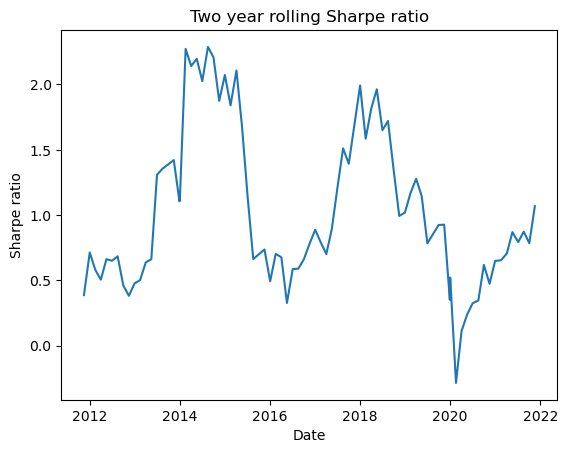

In [142]:
import matplotlib.pyplot as plt
plt.plot(rolling_sharpe)
plt.title('Two year rolling Sharpe ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe ratio')
plt.show()

In [54]:
# plot n_long against log long return
plt.scatter(returns_df['n_long'], returns_df['long_return'])
# set a logarithmic scale for the x axis
plt.xscale('log')
plt.xlabel('Number of long stocks')
plt.ylabel('Long return')
plt.title('Number of long stocks vs long return')
plt.show()

KeyError: 'long_return'

In [53]:
# plot n_short against short returns
plt.scatter(returns_df['n_short'], returns_df['short_return'])
# set a logarithmic scale for the x axis
plt.xscale('log')
plt.xlabel('Number of short stocks')
plt.ylabel('Short return')
plt.title('Number of short stocks vs short return')
plt.show()

KeyError: 'n_short'

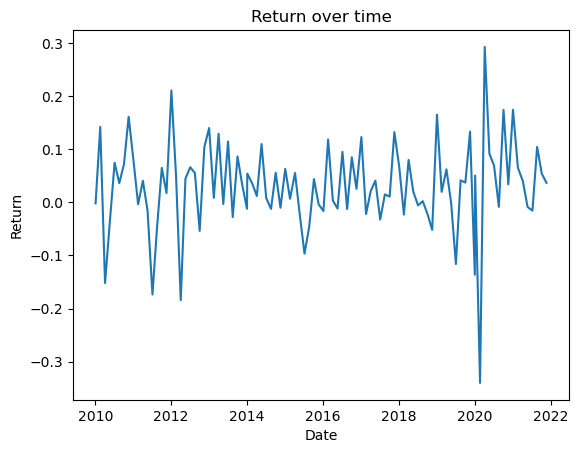

In [56]:
# plot return against date
plt.plot(returns_df['date'], returns_df['return'])
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Return over time')
plt.show()

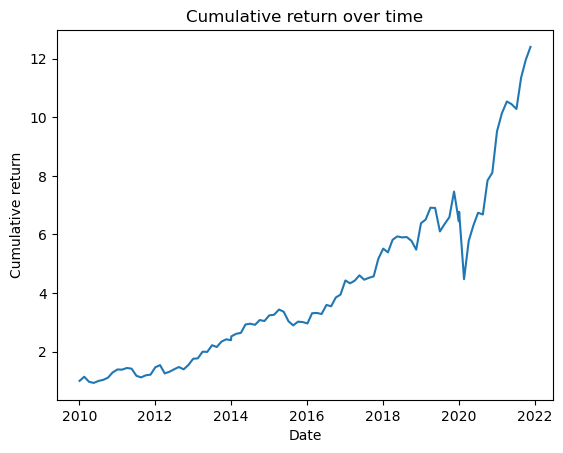

In [57]:
returns_df['cumpound_return'] = returns_df['return'].add(1).cumprod()

# plot cumulative return against date
plt.plot(returns_df['date'], returns_df['cumpound_return'])
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.title('Cumulative return over time')
plt.show()
